# Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt

# Load data


In [2]:
#  import raw data
def import_data(fileName):
    raw_data_df = pd.read_csv(fileName, header=0)
    return raw_data_df

In [3]:
# training data
raw_train_data_df = import_data('usage_train.csv')
raw_train_data_df.head()


,id,datetime,usage
0,MAC003828,2012-12-17 09:00:00,0.073
1,MAC003828,2012-12-17 09:30:00,0.054
2,MAC003828,2012-12-17 10:00:00,0.069
3,MAC003828,2012-12-17 10:30:00,0.070
4,MAC003828,2012-12-17 11:00:00,0.049


In [4]:
# test data
raw_test_data_df = import_data('usage_test.csv')
raw_test_data_df.head()


,id,datetime
0,MAC003828,2013-12-10 09:00:00
1,MAC003828,2013-12-10 09:30:00
2,MAC003828,2013-12-10 10:00:00
3,MAC003828,2013-12-10 10:30:00
4,MAC003828,2013-12-10 11:00:00


In [5]:
#  transform data
def transform(train,test,id):
    data=train.loc[(train.id == id)]
    data['ds']=pd.to_datetime(data['datetime'])
    train_data=data.loc[:, ['usage']]
    train_data = train_data.set_index([data.ds])
    train_data['usage'] = pd.to_numeric(train_data['usage'],downcast='float',errors='coerce')

    test_data=test.loc[(test.id == id)]
    test_data['ds']=pd.to_datetime(test_data['datetime'])
    
    return train_data, pd.DataFrame(test_data['ds'])


In [6]:
meter_id = 'MAC003828'
train,test = transform(raw_train_data_df,raw_test_data_df,meter_id) 

/home/anil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/anil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [7]:
train.head()

,usage
ds,
2012-12-17 09:00:00,0.073
2012-12-17 09:30:00,0.054
2012-12-17 10:00:00,0.069
2012-12-17 10:30:00,0.070
2012-12-17 11:00:00,0.049


In [8]:
test.head()

,ds
0,2013-12-10 09:00:00
1,2013-12-10 09:30:00
2,2013-12-10 10:00:00
3,2013-12-10 10:30:00
4,2013-12-10 11:00:00


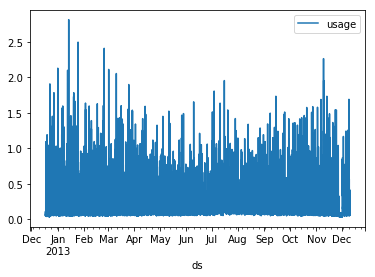

,usage
count,17184.000000
mean,0.215379
std,0.233891
min,0.030000
25%,0.089000
50%,0.126000
75%,0.237000
max,2.814000


In [9]:
# Visualise data
train.plot()
plt.show()
train.dropna().describe()

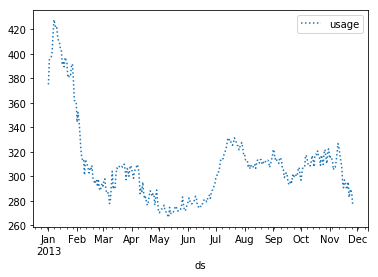

In [10]:
# daily visualisation
daily = train.resample('D').sum()
daily.rolling(30, center=True).sum().plot(style=[':', '--', '-'])

In [11]:
day= train.resample(rule='H').sum()
day.head()

,usage
ds,
2012-12-17 09:00:00,0.127
2012-12-17 10:00:00,0.139
2012-12-17 11:00:00,0.152
2012-12-17 12:00:00,0.200
2012-12-17 13:00:00,0.181


In [12]:
half_hours= train.resample(rule=('T',30)).sum()
half_hours.head()

,usage
ds,
2012-12-17 09:00:00,0.073
2012-12-17 09:30:00,0.054
2012-12-17 10:00:00,0.069
2012-12-17 10:30:00,0.070
2012-12-17 11:00:00,0.049


# Using Prophet package 

## Trainig with Prophet¶

In [13]:
# import packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import fbprophet

In [14]:
# transform data
daily_df = day
daily_df.reset_index(inplace=True)
# Prophet requires columns ds (Date) and y (value)
daily_df = daily_df.rename(columns={'date': 'ds', 'usage': 'y'})
daily_df.head()

,ds,y
0,2012-12-17 09:00:00,0.127
1,2012-12-17 10:00:00,0.139
2,2012-12-17 11:00:00,0.152
3,2012-12-17 12:00:00,0.200
4,2012-12-17 13:00:00,0.181


In [15]:
# train using prophet
def train(df):
    # Make the prophet model and fit on the data
    df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.010,yearly_seasonality=True,daily_seasonality=True)
    df_prophet.fit(df)
    warnings.resetwarnings()
    return df_prophet

In [16]:
prophet_model = train(daily_df)


# cross validation

INFO:fbprophet.diagnostics:Making 136 forecasts with cutoffs between 2013-01-01 20:00:00 and 2013-12-05 08:00:00
/home/anil/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


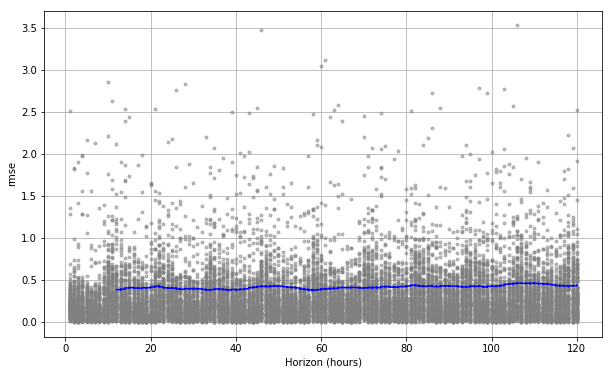

In [23]:
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric

df_cv = cross_validation(prophet_model,  horizon = '5 days')
fig = plot_cross_validation_metric(df_cv, metric='rmse')


In [24]:
# test using prophet
def predict(prophet_model,forecast):
    return prophet_model.predict(forecast)



In [25]:
from fbprophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
12731,12:00:00,0.148351,0.385164,0.253616,0.803725,0.906863
10212,13:00:00,0.148368,0.385186,0.253657,0.804004,0.906863
14052,13:00:00,0.148469,0.385317,0.253870,0.805181,0.906863
13692,13:00:00,0.148518,0.385380,0.253953,0.805344,0.906863
10452,13:00:00,0.148484,0.385336,0.253892,0.805460,0.906863


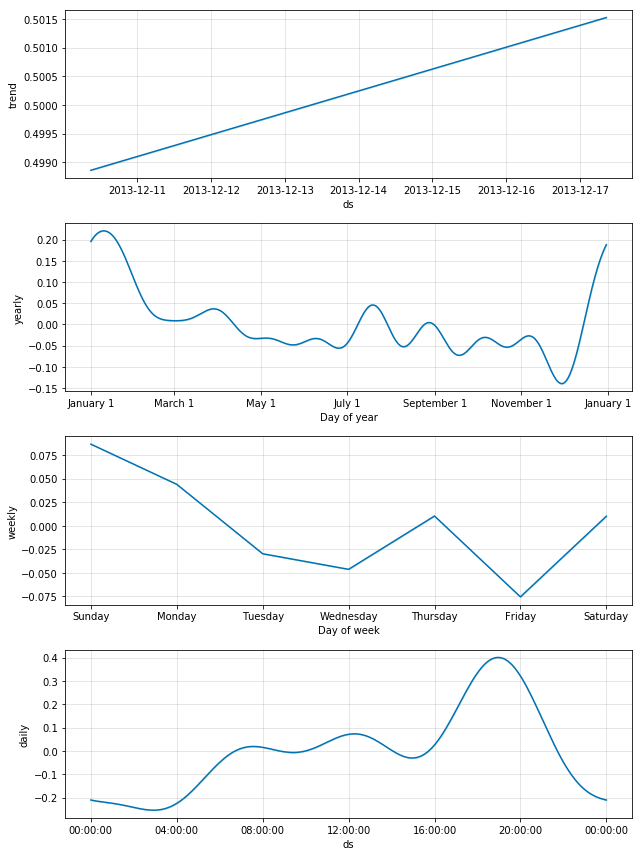

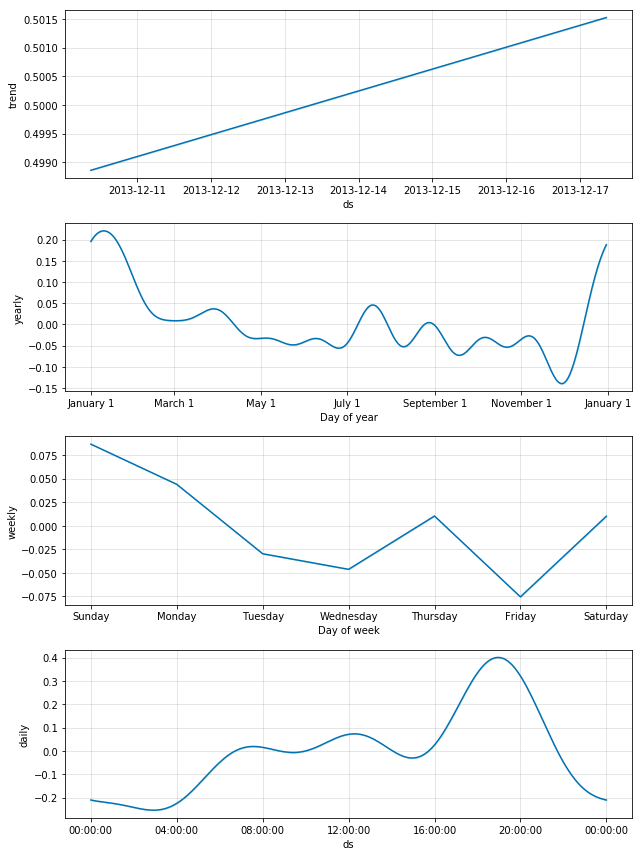

In [26]:
forecast = predict(prophet_model,test)
prophet_model.plot_components(forecast)


In [27]:
forecast.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2013-12-10 09:00:00,0.498860,0.498860,0.498860,-0.131550,0.873244,-0.123753,-0.123753,-0.123753,-0.003501,...,0.0,0.0,0.0,-0.056512,-0.056512,-0.056512,-0.063740,-0.063740,-0.063740,0.375107
1,2013-12-10 09:30:00,0.498868,0.498868,0.498868,-0.119553,0.850935,-0.127348,-0.127348,-0.127348,-0.006444,...,0.0,0.0,0.0,-0.057432,-0.057432,-0.057432,-0.063472,-0.063472,-0.063472,0.371520
2,2013-12-10 10:00:00,0.498875,0.498875,0.498875,-0.117284,0.860256,-0.121246,-0.121246,-0.121246,0.000231,...,0.0,0.0,0.0,-0.058274,-0.058274,-0.058274,-0.063204,-0.063204,-0.063204,0.377629
3,2013-12-10 10:30:00,0.498883,0.498883,0.498883,-0.096945,0.899857,-0.105764,-0.105764,-0.105764,0.016206,...,0.0,0.0,0.0,-0.059034,-0.059034,-0.059034,-0.062936,-0.062936,-0.062936,0.393120
4,2013-12-10 11:00:00,0.498891,0.498891,0.498891,-0.051852,0.886588,-0.084737,-0.084737,-0.084737,0.037641,...,0.0,0.0,0.0,-0.059710,-0.059710,-0.059710,-0.062667,-0.062667,-0.062667,0.414155


## Plot

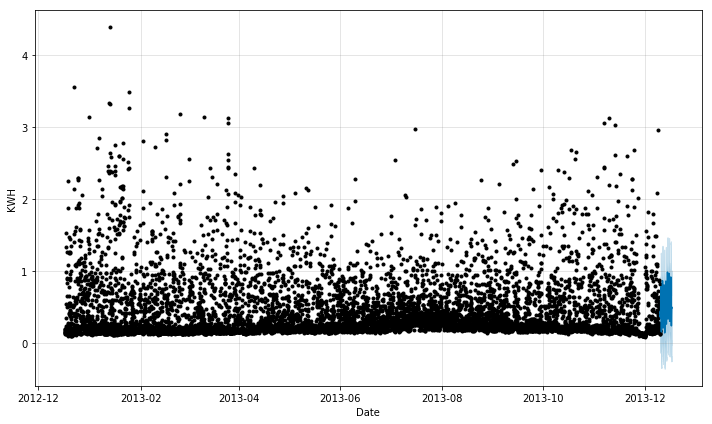

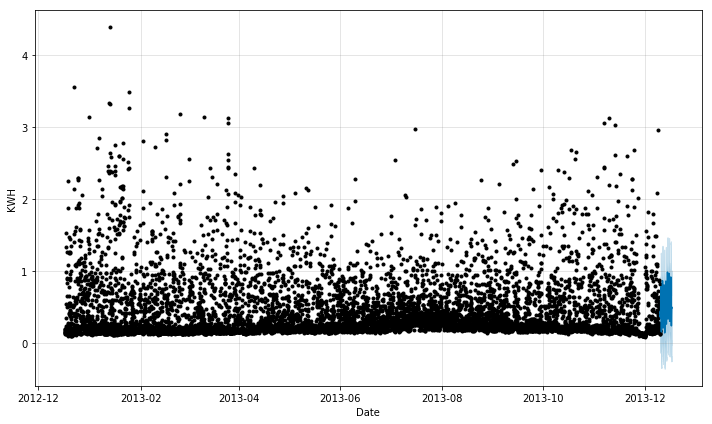

In [28]:
prophet_model.plot(forecast, xlabel = 'Date', ylabel = 'KWH')